In [1]:
import numpy as np
import matplotlib.pyplot as plt

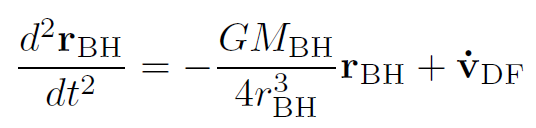

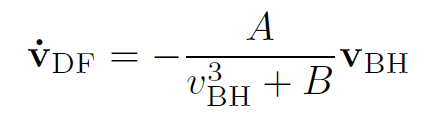

# (a) No dynamical friction (A = 0)

$$ T \approx \frac{2\pi r}{v} $$

$$ \mathbf{v}(t) = \mathbf{v}(t_0) + \int_{t_0}^t -\frac{G M \mathbf{r(t')}}{4 r(t')^3} dt' = \mathbf{v}(t_0) +  \int_{t_0}^t -\frac{G M}{4 r(t')^2} \hat{\mathbf{r(t')}} dt' = \mathbf{v}(t_0) + \frac{G M}{4r(t)} \hat{\mathbf{r}}$$

In [621]:
### Initially my code was too slow
### Avoid using np.linalg.norm and also don't pass around the state as a nested vector
def derivative(state, constants):
    G, M, A, B = constants
    x, y, vx, vy = state
    r2 = x*x + y*y
    r3 = r2 * np.sqrt(r2)
    v2 = vx*vx + vy*vy

    ax = -G * M * x / (4 * r3) - A * vx / (v2**1.5 + B)
    ay = -G * M * y / (4 * r3) - A * vy / (v2**1.5 + B)

    return np.array([vx, vy, ax, ay])

### RK4 integrator
def rk4_step(state, constants, h):
    k1 = derivative(state, constants)
    k2 = derivative(state + 0.5*h*k1, constants)
    k3 = derivative(state + 0.5*h*k2, constants)
    k4 = derivative(state + h*k3, constants)
    return state + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

### Adaptive time step
def adaptive_rk4(state0, t_max, h_init, tol, constants):
    t = 0.0
    h = h_init
    state = state0.copy()
    
    traj = []
    times = []
    delta = tol

    while t < t_max:
        # one double step
        state_double = rk4_step(state, constants, h)
        # two single steps
        state_single = rk4_step(state, constants, h/2)
        state_single = rk4_step(state_single, constants, h/2)
        
        r1 = np.array([state_double[0], state_double[1]])
        r2 = np.array([state_single[0], state_single[1]])
        error = np.linalg.norm(r1 - r2) 
        rho = 30 * delta * h / (error) # rho from the book

        if rho >= 1.0:
            state = state_single
            t += h
            traj.append(state.copy())
            times.append(h)
            h *= min(1.5, rho**0.25)
        else:
            h *= max(0.5, rho**0.25)
    
    return np.array(times), np.array(traj)


In [622]:
def adaptive_rk4(state0, t_max, h_init, tol, constants):
    G, M, A, B = constants
    t = 0.0
    h = h_init

    # flatten state: [x, y, vx, vy]
    state = state0.reshape(-1).copy()

    traj = []
    times = []
    delta = tol

    def deriv(s):
        x, y, vx, vy = s
        r2 = x*x + y*y
        r3 = r2 * np.sqrt(r2)
        v2 = vx*vx + vy*vy
        ax = -G*M*x / (4*r3) - A*vx / (v2**1.5 + B)
        ay = -G*M*y / (4*r3) - A*vy / (v2**1.5 + B)
        return np.array([vx, vy, ax, ay])

    def rk4_step_flat(s, h):
        k1 = deriv(s)
        k2 = deriv(s + 0.5*h*k1)
        k3 = deriv(s + 0.5*h*k2)
        k4 = deriv(s + h*k3)
        return s + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    while t < t_max:
        # One double step
        s_double = rk4_step_flat(state, h)
        # Two half steps
        s_half = rk4_step_flat(state, h*0.5)
        s_single = rk4_step_flat(s_half, h*0.5)

        # Error control (only position error)
        dx = s_double[0] - s_single[0]
        dy = s_double[1] - s_single[1]
        error = (dx*dx + dy*dy)**0.5

        # Compute rho (acceptance ratio)
        rho = 30 * delta * h / error

        if rho >= 1.0:
            state = s_single
            t += h
            traj.append(state.copy())
            times.append(t)
            # step size growth limited
            h *= min(1.5, rho**0.25)
        else:
            # step size shrink limited
            h *= max(0.5, rho**0.25)

    return np.array(times), np.array(traj)

In [623]:
G, M, A, B = 1.0, 1.0, 0.0, 0.0
constants = G, M, A, B
r_peri = 1e-7
v_circ = np.sqrt(G * M / 4)
v0 = 0.000446 * v_circ # we find this value by iteration to arrive at r_peri
state0 = np.array([1,0,0,v0])

r_target = 1e-7
tol = 1e-8
h_init = 1e-3

T_orbit = 2*np.pi * np.sqrt(4 / (G*M))  # approximate period
t_max = 4*T_orbit # also we vary this to have 10 orbits (would have expected to use 10*T_orbit but that was too much)

times, traj = adaptive_rk4(state0, t_max, h_init, tol, constants)
times2, traj2, = adaptive_rk4(state0, t_max, h_init, 1e-7, constants)

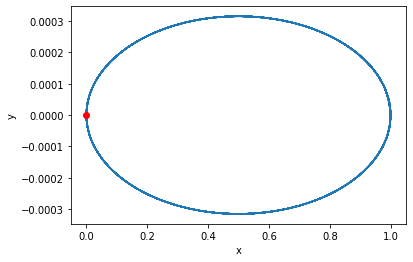

In [624]:
plt.plot(traj[:,0], traj[:,1])
plt.plot(0,0,'ro')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig('figures/BH_trajectory_no_df.png', dpi=300, bbox_inches='tight')

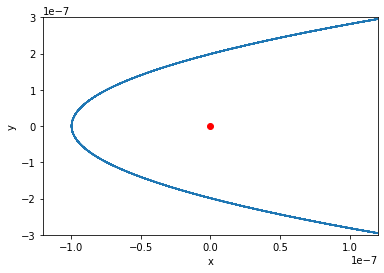

In [625]:
plt.plot(traj[:,0], traj[:,1])
plt.plot(0,0,'ro')
plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-1.2e-7,1.2e-7)
plt.ylim(-3e-7,3e-7)

plt.savefig('figures/BH_trajectory_no_df_zoom_in.png', dpi=300, bbox_inches='tight')

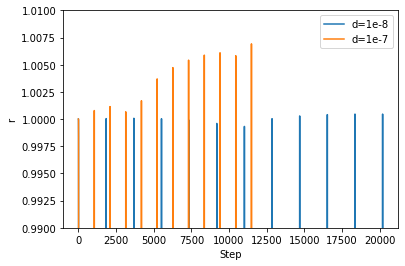

In [627]:
x = traj[:,0]
y = traj[:,1]
x2 = traj2[:,0]
y2 = traj2[:,1]
norm = np.sqrt(x**2 + y**2)
norm2 = np.sqrt(x2**2 + y2**2)
plt.plot(norm, label='d=1e-8')
plt.plot(norm2, label='d=1e-7')
plt.ylim(0.99,1.01)
plt.xlabel('Step')
plt.ylabel('r')
plt.legend()

plt.savefig('figures/BH_r_comparison.png', dpi=300, bbox_inches='tight')

In [628]:
np.min(traj[:,0])
np.max(traj[:,0])

1.0004617670007963

# (b)

In [553]:
def adaptive_rk4_b(state0, t_max, h_init, tol, constants, r_target):
    G, M, A, B = constants
    t = 0.0
    h = h_init

    # flatten state: [x, y, vx, vy]
    state = state0.reshape(-1).copy()

    traj = []
    times = []
    delta = tol

    def deriv(s):
        x, y, vx, vy = s
        r2 = x*x + y*y
        r3 = r2 * np.sqrt(r2)
        v2 = vx*vx + vy*vy
        ax = -G*M*x / (4*r3) - A*vx / (v2**1.5 + B)
        ay = -G*M*y / (4*r3) - A*vy / (v2**1.5 + B)
        return np.array([vx, vy, ax, ay])

    def rk4_step_flat(s, h):
        k1 = deriv(s)
        k2 = deriv(s + 0.5*h*k1)
        k3 = deriv(s + 0.5*h*k2)
        k4 = deriv(s + h*k3)
        return s + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    while t < t_max:
        # One double step
        s_double = rk4_step_flat(state, h)
        # Two half steps
        s_half = rk4_step_flat(state, h*0.5)
        s_single = rk4_step_flat(s_half, h*0.5)

        # Error control (only position error)
        dx = s_double[0] - s_single[0]
        dy = s_double[1] - s_single[1]
        error = (dx*dx + dy*dy)**0.5

        # Compute rho (acceptance ratio)
        rho = 30 * delta * h / (error + 1e-40)

        if rho >= 1.0:
            state = s_single
            t += h
            traj.append(state.copy())
            times.append(t)
            # step size growth limited
            h *= min(1.5, rho**0.25)
        else:
            # step size shrink limited
            h *= max(0.5, rho**0.25)

        # Early stop if inside target radius
        rmag = (state[0]**2 + state[1]**2)**0.5
        if rmag < r_target:
            break

    return np.array(times), np.array(traj), rmag

In [554]:
G, M, A, B = 1.0, 1.0, 1.0, 1.0
constants = G, M, A, B
r_peri = 1e-7
v_circ = np.sqrt(G * M / 4)
v0 = 0.8 * v_circ
state0 = np.array([1,0,0,v0])

r_target = 1e-7
tol = 1e-8
h_init = 1e-3

T_orbit = 2*np.pi * np.sqrt(4 / (G*M))  # approximate period
t_max = 10*T_orbit + 7

times_b, traj_b, final_r = adaptive_rk4_b(state0, t_max, h_init, tol, constants, r_target)

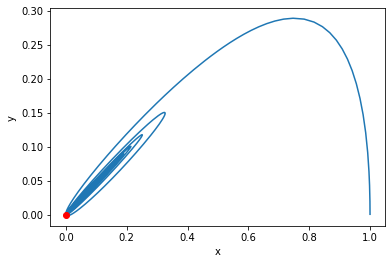

In [555]:
plt.plot(traj_b[:,0], traj_b[:,1])
plt.plot(0,0,'ro')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig('figures/BH_trajectory_with_df.png', dpi=300, bbox_inches='tight')

In [556]:
final_r

9.981621889022825e-08

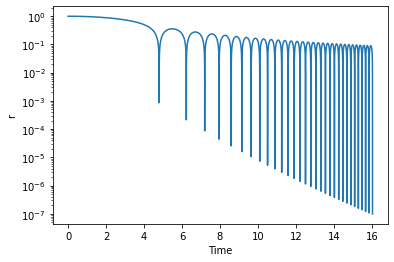

In [609]:
plt.plot(time_convert(times_b), np.linalg.norm(traj_b[:,0:2], axis=1))
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('r')

plt.savefig('figures/BH_r_vs_time_with_df.png', dpi=300, bbox_inches='tight')

# (c)

In [629]:
def time_convert(t):
    Myr = 0.9778*(100**3/(4.302e-3 * 1e8))**0.5 * t
    return Myr

In [651]:
As = np.linspace(0.5, 10, 10)
Bs = np.linspace(0.5, 10, 10)

times = []
trajectories = []
ratios = []

v0 = 0.8 * v_circ
state0 = np.array([1,0,0,v0])

for A in As:
    for B in Bs:
        constants = 1, 1, A, B
        if 0.5 <= A / B and A / B <= 10:
            times_c, traj_c, final_r = adaptive_rk4_b(state0, t_max, h_init, tol, constants, r_target)
            times.append(times_c[-1])
            trajectories.append(traj_c)
            ratios.append(A / B)

In [649]:
times = np.array(times)
ratios = np.array(ratios)

order = np.argsort(ratios)
ratios_sorted = ratios[order]
times_sorted = times[order]

Text(0, 0.5, 'Time to reach $r_s$ [Myr]')

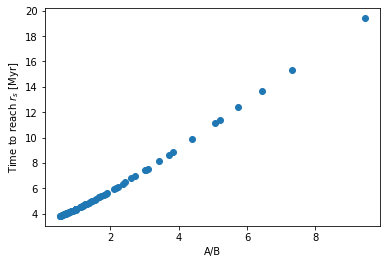

In [650]:
plt.plot(ratios_sorted, time_convert(times_sorted), 'o')
plt.xlabel('A/B')
plt.ylabel(r'Time to reach $r_s$ [Myr]')

In [637]:
indexes = []
for i, A in enumerate(As):
    for j, B in enumerate(Bs):
        if 0.5 <= A / B and A / B <= 10:
            indexes.append((i,j))

In [638]:
# find positions in `indexes` where the first element (i) equals 4 to keep A fixed

idx_i4 = [pos for pos, (ii, jj) in enumerate(indexes) if ii == 4]

print("positions:", idx_i4)
print("tuples:", [indexes[p] for p in idx_i4])
print("A/B values:", [As[ii]/Bs[jj] for (ii,jj) in [indexes[p] for p in idx_i4]])

positions: [16, 17, 18, 19, 20, 21, 22, 23, 24]
tuples: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8)]
A/B values: [9.444444444444445, 3.0357142857142856, 1.8085106382978724, 1.2878787878787878, 1.0, 0.8173076923076923, 0.6910569105691057, 0.5985915492957746, 0.5279503105590062]


In [639]:
idx_j1 = [pos for pos, (ii, jj) in enumerate(indexes) if jj == 1]

print("positions:", idx_j1)
print("tuples:", [indexes[p] for p in idx_j1])
print("A/B values:", [As[ii]/Bs[jj] for (ii,jj) in [indexes[p] for p in idx_j1]])

positions: [2, 5, 10, 17, 25, 34, 43, 52, 61]
tuples: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
A/B values: [1.0, 1.6785714285714286, 2.357142857142857, 3.0357142857142856, 3.714285714285714, 4.392857142857143, 5.071428571428571, 5.75, 6.428571428571429]


In [640]:
idx_j7 = [pos for pos, (ii, jj) in enumerate(indexes) if jj == 7]

print("positions:", idx_j7)
print("tuples:", [indexes[p] for p in idx_j7])
print("A/B values:", [As[ii]/Bs[jj] for (ii,jj) in [indexes[p] for p in idx_j7]])

positions: [23, 31, 40, 49, 58, 67]
tuples: [(4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7)]
A/B values: [0.5985915492957746, 0.732394366197183, 0.8661971830985916, 1.0, 1.1338028169014085, 1.2676056338028168]


In [641]:
idx_i9 = [pos for pos, (ii, jj) in enumerate(indexes) if ii == 9]

print("positions:", idx_i9)
print("tuples:", [indexes[p] for p in idx_i9])
print("A/B values:", [As[ii]/Bs[jj] for (ii,jj) in [indexes[p] for p in idx_i9]])

positions: [61, 62, 63, 64, 65, 66, 67, 68, 69]
tuples: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
A/B values: [6.428571428571429, 3.829787234042553, 2.727272727272727, 2.1176470588235294, 1.7307692307692308, 1.4634146341463414, 1.2676056338028168, 1.1180124223602483, 1.0]


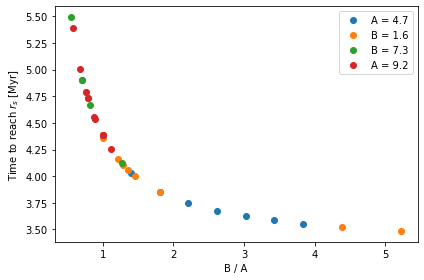

In [ ]:
plt.plot(ratios[idx_i4], time_convert(times[idx_i4]), 'o', label='A = 4.7')
    
plt.plot(ratios[idx_j1], time_convert(times[idx_j1]), 'o', label='B = 1.6')

plt.plot(ratios[idx_j7], time_convert(times[idx_j7]), 'o', label='B = 7.3')

plt.plot(ratios[idx_i9], time_convert(times[idx_i9]), 'o', label='A = 9.2')
    
plt.xlim(0, 11)
plt.ylim(5, max(times)*1.6)
plt.xlabel('A / B')
plt.ylabel('Time to reach $r_s$ [Myr]')
plt.legend()
plt.tight_layout()

plt.savefig('figures/BH_time_vs_A_over_B_special_lines.png', dpi=300, bbox_inches='tight')

# (d)

In [586]:
# repeat above exercise ish but with different initial velocity

ratio = 1
B = 1.0
A = ratio * B
constants = 1, 1, A, B
v0s = np.linspace(0.1, 1.5, 10) * v_circ

times_d_list = []
trajectories_d = []

for v0 in v0s:
    state0 = np.array([1,0,0,v0])
    times_d, traj_d, final_r = adaptive_rk4_b(state0, t_max, h_init, tol, constants, r_target)
    trajectories_d.append(traj_d)
    times_d_list.append(times_d[-1])

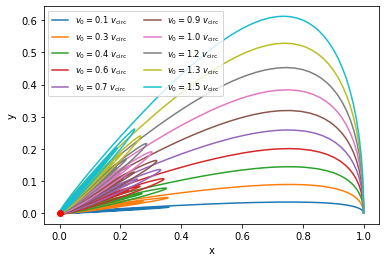

In [615]:
subscript = '\mathrm{circ}'
for i, traj in enumerate(trajectories_d):
    plt.plot(traj[:,0], traj[:,1], label=fr'$v_0=${v0s[i]/v_circ:.1f} $v_{subscript}$')
plt.plot(0,0,'ro')
plt.xlabel('x') 
plt.ylabel('y')
plt.legend(ncol=2, fontsize='small')

plt.savefig('figures/BH_trajectories_different_initial_velocities.png', dpi=300, bbox_inches='tight')

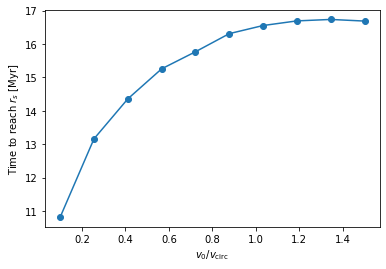

In [619]:
plt.plot(v0s / v_circ, time_convert(np.array(times_d_list)), 'o-')
plt.xlabel(r'$v_0 / v_{\mathrm{circ}}$')
plt.ylabel('Time to reach $r_s$ [Myr]')
plt.savefig('figures/BH_time_to_rs_vs_initial_velocity.png', dpi=300, bbox_inches='tight')